In [67]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [12]:
#wczytywanie pliku z danymi
dane = pd.read_csv('CMC_dataset.csv')

In [13]:
dane

,Unnamed: 0,Compound No.,Mol. Wgt.,Name,Additives,Temperature,CMC Value / M,SMILES_y
0,0,1,288.3,SODIUM DODECYL 1 SULFATE,NaN,25.0,0.006348,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]
1,1,2,232.2,SODIUM OCTYL 1 SULFATE,NaN,25.0,0.070000,CCCCC(CC)COS(=O)(=O)[O-].[Na+]
2,2,3,260.3,SODIUM DECYL 1 SULFATE,NaN,25.0,0.031000,CCCCCCCCCCOS(=O)(=O)[O-].[Na+]
3,3,4,316.4,SODIUM TETRADECYL 1 SULFATE,NaN,25.0,0.001400,CCCCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]
4,4,5,344.4,SODIUM HEXADECYL 1 SULFATE,NaN,25.0,0.000210,CCCCCCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]
...,...,...,...,...,...,...,...,...
206,208,692,234.4,DECYL SULFINYLETHANOL,NaN,25.0,0.000004,C(CCCCO)CCCCS
207,209,717,378.4,DODECYLQUINOLINIUM BROMIDE,NaN,25.0,0.004800,CCCCCCCCCCS(=O)CCO
208,210,112,339.5,TETRAMETHYL AMMONIUM DODECYL 1 SULFATE,NaN,25.0,0.005500,CCCCCCCCCCCC[N+]1=CC2=CC=CC=C2C=C1.[Br-]
209,211,113,420.5,SODIUM DODECYL TRI-0XYETHYLENE SULFATE,NaN,25.0,0.000100,CCCC[N+](CCCC)(CCCC)CCCC.OS(=O)(=O)[O-]


In [14]:
#wczytywanie kluczowych wartości
CMC = dane.iloc[:, 6]
logCMC = np.log(CMC)
smiles = dane.iloc[:, 7]

In [19]:
#tworzenie deskryptorów
df = pd.DataFrame({'SMILES': smiles})
df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

df['masa molowa'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)            
df['logp'] = df['mol'].apply(Crippen.MolLogP) 
df['TPSA'] = df['mol'].apply(rdMolDescriptors.CalcTPSA)
df['liczba at. węgla'] = df['mol'].apply(lambda m: sum(atom.GetSymbol() == 'C' for atom in m.GetAtoms()))
df['linearity'] = df['mol'].apply(rdMolDescriptors.CalcChi0v)

In [22]:
X = df[['TPSA', 'liczba at. węgla', 'masa molowa', 'logp', 'linearity']]
y = logCMC 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

R²: 0.2538968091233049


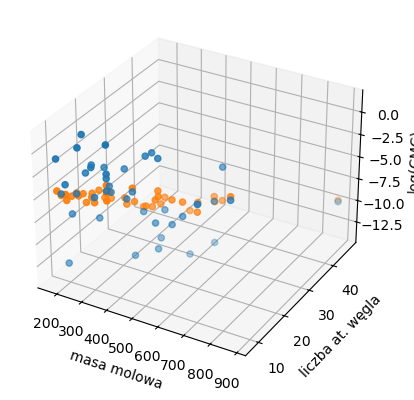

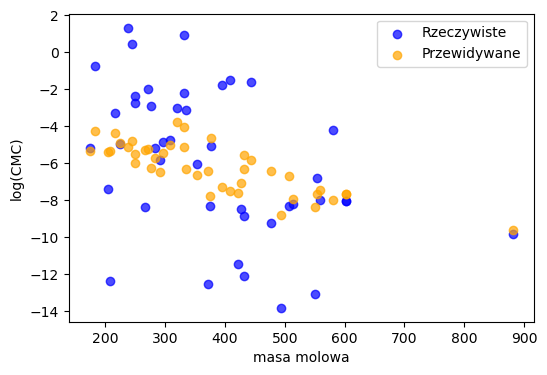

In [45]:
#tworzenie modelu regresji liniowej

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test['masa molowa'], X_test['liczba at. węgla'], y_test)
ax.scatter(X_test['masa molowa'], X_test['liczba at. węgla'], y_pred)

ax.set_xlabel('masa molowa')
ax.set_ylabel('liczba at. węgla')
ax.set_zlabel('log(CMC)')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(X_test['masa molowa'], y_test, color='blue', alpha=0.7, label='Rzeczywiste')
plt.scatter(X_test['masa molowa'], y_pred, color='orange', alpha=0.7, label='Przewidywane')
plt.xlabel('masa molowa')
plt.ylabel('log(CMC)')
plt.legend()
plt.show()

In [65]:
#regresja wielomianowa

X = df[['TPSA', 'liczba at. węgla', 'masa molowa', 'logp', 'linearity']]
y = logCMC 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


poly = PolynomialFeatures(degree = 2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred_poly = model.predict(X_test_poly)


r2 = r2_score(y_test, y_pred_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)

R²: 0.16683484514904678


R²: 0.22722503912605574


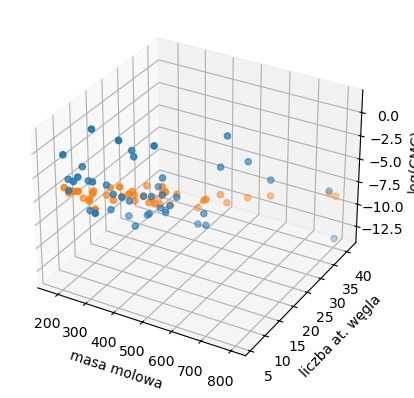

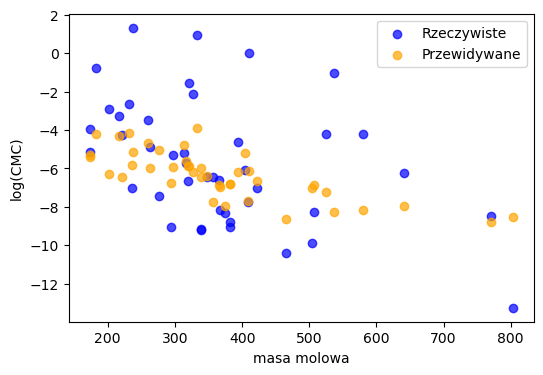

In [76]:
#regularyzacja

X = df[['TPSA', 'liczba at. węgla', 'masa molowa', 'logp', 'linearity']]
y = logCMC 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ridge = Ridge(alpha = 5.0)  # alpha = siła regularizacji
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("R²:", r2)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(X_test['masa molowa'], X_test['liczba at. węgla'], y_test)
ax.scatter(X_test['masa molowa'], X_test['liczba at. węgla'], y_pred_ridge)

ax.set_xlabel('masa molowa')
ax.set_ylabel('liczba at. węgla')
ax.set_zlabel('log(CMC)')
plt.show()



plt.figure(figsize=(6,4))
plt.scatter(X_test['masa molowa'], y_test, color='blue', alpha=0.7, label='Rzeczywiste')
plt.scatter(X_test['masa molowa'], y_pred_ridge, color='orange', alpha=0.7, label='Przewidywane')
plt.xlabel('masa molowa')
plt.ylabel('log(CMC)')
plt.legend()
plt.show()